<a href="https://colab.research.google.com/github/DzikriDhaniawan/diabetes_factor/blob/main/diabetes_factor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Diabetes Highest Factor**

Analisis Faktor Dominan Risiko Diabetes Berdasarkan Kelompok Usia dan Gaya Hidup

Import dataset dari kaggle

In [ ]:
import kagglehub
from kagglehub import KaggleDatasetAdapter

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

In [ ]:
path = kagglehub.dataset_download("vishardmehta/diabetes-risk-prediction-dataset")

print(path)

Using Colab cache for faster access to the 'diabetes-risk-prediction-dataset' dataset.
/kaggle/input/diabetes-risk-prediction-dataset


In [ ]:
df = pd.read_csv(os.path.join(path, "diabetes_risk_dataset.csv"))

df.head()

,Patient_ID,age,gender,bmi,blood_pressure,fasting_glucose_level,insulin_level,HbA1c_level,cholesterol_level,triglycerides_level,physical_activity_level,daily_calorie_intake,sugar_intake_grams_per_day,sleep_hours,stress_level,family_history_diabetes,waist_circumference_cm,diabetes_risk_score,diabetes_risk_category
0,1,77,Female,33.8,154,93,12.1,5.2,242,194,Low,2169,78.4,8.1,4,No,101.1,52.3,Prediabetes
1,2,54,Male,19.2,123,94,4.6,5.4,212,76,High,1881,16.5,6.6,3,No,60.0,3.7,Low Risk
2,3,25,Male,33.7,141,150,10.8,6.9,247,221,Low,2811,147.9,6.7,10,Yes,114.7,87.3,High Risk
3,4,23,Female,32.8,140,145,11.6,6.8,195,193,Low,2826,98.3,4.4,9,Yes,96.6,76.1,High Risk
4,5,70,Male,33.7,165,90,18.3,5.6,217,170,Moderate,2610,65.8,9.1,5,Yes,107.4,47.7,Prediabetes


Drop/ hapus kolom yang tidak digunakan dengan tujuan menghindari model "mencontek" atau mencontoh langsung jawaban dari variabel turunan

In [ ]:
df = df.drop(columns=["Patient_ID", "diabetes_risk_score"])

Mengelompokkan umur pada tabel dengan tujuan menganalisis apakah faktor risiko berbeda pada setiap kelompok usia

In [ ]:
def age_group(age):
    if age < 25:
        return "Remaja"
    elif age < 45:
        return "Dewasa"
    else:
        return "Lansia"

df["Age_Group"] = df["age"].apply(age_group)

Melihat jumlah distribusi per umur

In [ ]:
df['Age_Group'].value_counts()

,count
Age_Group,
Lansia,3710
Dewasa,1831
Remaja,459


Menampilkan proporsi kategori (low risk, prediabets, high risk) pada tiap kelompok umur

In [ ]:
pd.crosstab(df["Age_Group"], df["diabetes_risk_category"], normalize="index")

diabetes_risk_category,High Risk,Low Risk,Prediabetes
Age_Group,,,
Dewasa,0.277444,0.543419,0.179137
Lansia,0.439084,0.364151,0.196765
Remaja,0.235294,0.557734,0.206972


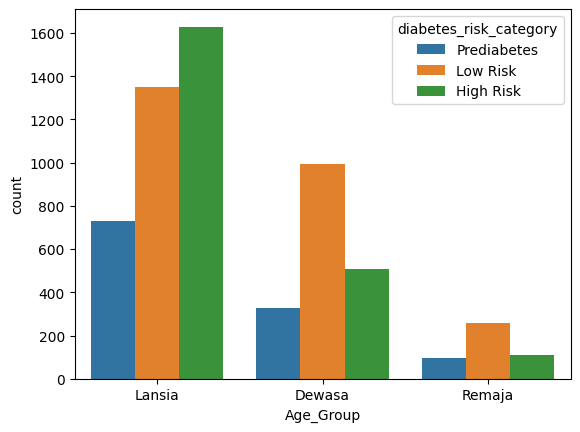

In [ ]:
sns.countplot(x="Age_Group", hue="diabetes_risk_category", data=df)
plt.show()

Encoding Target dengan tujuan mengubah kategori risiko menjadi angka,
1 = low risk,
2 = prediabetes, dan
3 = high risk


In [ ]:
le = LabelEncoder()
df["diabetes_risk_category"] = le.fit_transform(df["diabetes_risk_category"])

Encoding fitur kategorikal menjadi format numerik menggunakan One Hot Encoding dengan tujuan agar model bisa memproses data kategorikal

In [ ]:
df_encoded = pd.get_dummies(
    df,
    columns=["physical_activity_level", "family_history_diabetes", "gender"],
    drop_first=True
)

Pisahkan antara fitur dan target

In [ ]:
X = df_encoded.drop(columns=["diabetes_risk_category", "Age_Group"])
y = df_encoded["diabetes_risk_category"]

Melakukan split untuk data train dan juga data test

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Training model menggunakan Logistic Regression untuk memprediksi kategori risiko berdasarkan indikator kesehatan dan gaya hidup

In [ ]:
model = LogisticRegression(multi_class="multinomial", max_iter=1000 )
model.fit(X_train_scaled, y_train)

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


LogisticRegression(max_iter=1000, multi_class='multinomial')

Mengukur performa model secara detail per kelas

In [ ]:
y_pred = model.predict(X_test_scaled)
print(classification_report(y_test, y_pred, target_names=le.classes_))

              precision    recall  f1-score   support

   High Risk       0.98      0.97      0.98       449
    Low Risk       0.96      0.95      0.95       520
 Prediabetes       0.84      0.86      0.85       231

    accuracy                           0.94      1200
   macro avg       0.93      0.93      0.93      1200
weighted avg       0.94      0.94      0.94      1200



Menampilkan bobot setiap fitur terhadap high risk, low risk, dan prediabetes. Dengan tujuan mengetahui faktor paling berpengaruh terhadap risiko diabetes

In [ ]:
coef = pd.DataFrame(
    model.coef_,
    columns=X.columns,
    index=le.classes_
)

coef

,age,bmi,blood_pressure,fasting_glucose_level,insulin_level,HbA1c_level,cholesterol_level,triglycerides_level,daily_calorie_intake,sugar_intake_grams_per_day,sleep_hours,stress_level,waist_circumference_cm,physical_activity_level_Low,physical_activity_level_Moderate,family_history_diabetes_Yes,gender_Male
High Risk,2.048870,3.779816,0.124753,6.169794,-0.013065,0.796619,0.073674,0.172698,0.149265,-0.013105,-0.028796,0.129927,4.737818,0.749228,-0.134656,1.606426,-1.292775
Low Risk,-2.150794,-3.375423,-0.208174,-6.386340,-0.048732,-0.703874,-0.008036,-0.242253,-0.347283,0.094277,-0.025683,-0.119347,-4.585707,-1.210081,-0.270408,-1.721115,1.239269
Prediabetes,0.101924,-0.404393,0.083420,0.216546,0.061797,-0.092745,-0.065638,0.069555,0.198018,-0.081172,0.054480,-0.010579,-0.152111,0.460854,0.405064,0.114688,0.053506


In [ ]:
coef.T.sort_values(by="High Risk", ascending=False).head(10)

,High Risk,Low Risk,Prediabetes
fasting_glucose_level,6.169794,-6.386340,0.216546
waist_circumference_cm,4.737818,-4.585707,-0.152111
bmi,3.779816,-3.375423,-0.404393
age,2.048870,-2.150794,0.101924
family_history_diabetes_Yes,1.606426,-1.721115,0.114688
HbA1c_level,0.796619,-0.703874,-0.092745
physical_activity_level_Low,0.749228,-1.210081,0.460854
triglycerides_level,0.172698,-0.242253,0.069555
daily_calorie_intake,0.149265,-0.347283,0.198018
stress_level,0.129927,-0.119347,-0.010579


Melihat apakah faktor penyebab kategori diabetes dominan berbeda di tiap kelompok usia

In [ ]:
def analyze_group(group_name):
    print(f"\n ANALISIS KELOMPOK {group_name.upper()}")

    df_group = df_encoded[df_encoded["Age_Group"] == group_name]

    X_g = df_group.drop(columns=["diabetes_risk_category", "Age_Group"])
    y_g = df_group["diabetes_risk_category"]

    X_train, X_test, y_train, y_test = train_test_split(
        X_g, y_g, test_size=0.2, random_state=42, stratify=y_g
    )

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    model = LogisticRegression(multi_class="multinomial", max_iter=1000)
    model.fit(X_train_scaled, y_train)

    y_pred = model.predict(X_test_scaled)

    print(classification_report(y_test, y_pred, target_names=le.classes_))

    coef = pd.DataFrame(
        model.coef_,
        columns=X_g.columns,
        index=le.classes_
    )

    print("\nTop faktor High Risk:")
    print(coef.T.sort_values(by="High Risk", ascending=False).head(7))

In [ ]:
analyze_group("Remaja")
analyze_group("Dewasa")
analyze_group("Lansia")


 ANALISIS KELOMPOK REMAJA
              precision    recall  f1-score   support

   High Risk       0.83      0.86      0.84        22
    Low Risk       0.98      0.92      0.95        51
 Prediabetes       0.67      0.74      0.70        19

    accuracy                           0.87        92
   macro avg       0.82      0.84      0.83        92
weighted avg       0.88      0.87      0.87        92


Top faktor High Risk:
                             High Risk  Low Risk  Prediabetes
fasting_glucose_level         1.978522 -2.437303     0.458781
waist_circumference_cm        1.817940 -1.641937    -0.176002
bmi                           1.676206 -2.062613     0.386407
HbA1c_level                   1.514730 -1.039772    -0.474957
daily_calorie_intake          1.439919 -1.185528    -0.254391
family_history_diabetes_Yes   0.688485 -0.953233     0.264748
blood_pressure                0.381766 -0.450724     0.068958

 ANALISIS KELOMPOK DEWASA
              precision    recall  f1-score   

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


              precision    recall  f1-score   support

   High Risk       0.98      0.97      0.97       326
    Low Risk       0.97      0.96      0.96       270
 Prediabetes       0.86      0.90      0.88       146

    accuracy                           0.95       742
   macro avg       0.94      0.94      0.94       742
weighted avg       0.95      0.95      0.95       742


Top faktor High Risk:
                             High Risk  Low Risk  Prediabetes
fasting_glucose_level         5.138782 -5.469607     0.330825
waist_circumference_cm        4.249210 -3.714303    -0.534908
bmi                           3.398449 -2.995371    -0.403078
family_history_diabetes_Yes   1.515014 -1.579187     0.064173
age                           1.090239 -1.092706     0.002468
HbA1c_level                   0.989119 -0.732300    -0.256818
physical_activity_level_Low   0.750679 -1.246531     0.495852


**Kesimpulan terkait dataset**


---


Berdasarkan analisis model, fasting glucose level, waist circumference, dan BMI merupakan tiga faktor paling dominan dalam menentukan kategori risiko diabetes pada seluruh kelompok usia dalam dataset ini.